<center>
<hr>
<h1>Digital Epidemiology</h1>
<h2>Assignment No. 1 - SIR</h2>
<h2>Giacomo Legnaro</h2>
<hr>
</center>

In this assignment i have choose *LiveJournal* networks graph. 

LiveJournal is a free on-line community with almost 10 million members; a significant fraction of these members are highly active. (For example, roughly 300,000 update their content in any given 24-hour period.) LiveJournal allows members to maintain journals, individual and group blogs, and it allows people to declare which other members are their friends they belong.

Nodes are users of LiveJournal, and directed edges represent friendships. In the dataset downloaded the edges are directed, but to do this assignment i have considered undirected edges.

A briefly summary of the dataset

<img src="summary_live_journal.png">

At the beginning is necessary to import the libraries. In this case we have upload data of a graph larger than 1 milion of nodes and to managed it we have used *igraph* library instead of networkx

In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import pylab
import random
import itertools
from operator import itemgetter
from igraph import *
%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 6)
# set all plot figure dimensions

### Part 1.1

Select the file of the dataset to upload

In [2]:
filename = 'soc-LiveJournal1.txt'

Upload the raw dataset and clean it from the first rows start with '#' character and consider only the first two values for each row that are the nodes (vertex) of the edges.

In [3]:
# this cell could be not run after the first time
data = []
with open(filename) as f:    
    for line in f:
        if line.startswith('#'):
            continue
        else:
            data.append(str(line.split()[0])+'\t'+ str(line.split()[1])+'\n')

In [4]:
w_filename = filename.strip('.txt') + '_treated' + '.txt'

In [5]:
# this cell could be not run after the first time
with open(w_filename, 'wb') as f:
    f.writelines(list(data))

Now it's time to create the graph with *igraph*. We have loaded the dataset directly from the file created and we have choose undirected graph.

In [6]:
G_raw = Graph.Read_Ncol(w_filename, directed = False)

In [7]:
print "The graph have ", G_raw.vcount(), " nodes and ", G_raw.ecount(), " edges" 

The graph have  4847571  nodes and  68993773  edges


In a first study of the assignment we have see that the graph is much bigger to compute the study in a limited time, and we have select randomly 35% of the total nodes: the percentage is choosen to have a set of nodes greater than 1 million.

In [8]:
v_rnd = random.sample(range(G_raw.vcount()), int(G_raw.vcount()*0.35))

After a selection of the induced subgraph, I have choose the giant connected subgraph.

In [9]:
G = G_raw.subgraph(v_rnd).components().giant()

In [10]:
print "The sub-graph considered have ", G.vcount(), " nodes and ", G.ecount(), " edges" 

The sub-graph considered have  1222926  nodes and  8369335  edges


To reduce computational time after, at each nodes I have update the dictionary with the degree and the unique list of the neighbors.
The degree of a node in a network is the number of connections or edges the node has to other nodes (sum of the in and out -connections).

In [11]:
for i in range(G.vcount()):
    G.vs[i]["degree"] = G.degree(i)

In [12]:
for i in range(G.vcount()):
    G.vs[i]["neighbors"] = list(set(G.neighbors(i)))

Next step is dedicated to see the degree distribution. The degree distribution is the probability that a randomly chosen node has  connections (or neighbors).

In [45]:
def degree_distribution(G):
    degree = {}
    for d in G.degree():
        degree[d] = 1 if d not in degree else (degree[d]+1)

    nodes = []
    frequency = []
    for d,f in degree.items():
        nodes.append(d), frequency.append(f)
    seq_sort = [f[0] for f in sorted(enumerate(frequency), reverse=True, key=lambda x:x[1])]
    nodes = [nodes[i] for i in seq_sort]
    frequency = [frequency[i]/float(G.vcount()) for i in seq_sort]
    
    return nodes, frequency

In [46]:
nodes, frequency = degree_distribution(G)

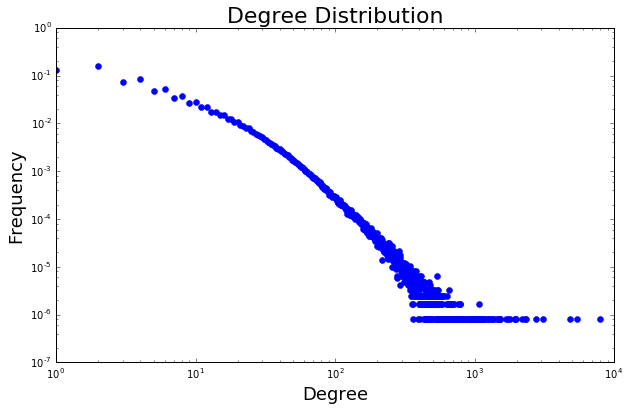

In [47]:
plt.figure()
plt.loglog(nodes, frequency, 'bo', fillstyle='full', markeredgecolor='b')
plt.xlabel('Degree', fontsize=18)
plt.ylabel('Frequency', fontsize=18)
plt.title('Degree Distribution', fontsize=22)
plt.show()

As expected there are a lot of nodes with low degree and a few with an high degree.

### Part 1.2

In this part we have set up a simulation of an SIR epidemic model. We have used as guideline the notebook see at lesson, but we have try to optimize and rearranged with the igraph library.

This function is written to be called at the next steps only change the input arguments.

In [16]:
def SIR_model(G,mu,beta,itrs,seed,flag,sentinels=[]):
    G.itr = {i:[] for i in range(itrs)}
    
    for itr in range(itrs):
        t = 0 # Initialize time
        I_net = [] # used to store the history of the system
        infected_nodes = [seed] # list of infected nodes
        # we need to store the disease status of each node S=0, I=1, R=-1
        G.vs["disease_status"] = np.zeros(G.vcount(), dtype = int)
        G.vs[seed]["disease_status"] = 1
        I_net.append(len(infected_nodes))
        
        while len(infected_nodes) > 0: 
            # loop until there are infectious nodes
            t += 1
            infect = list(set([i for i in list(set(itertools.chain.from_iterable(G.vs[infected_nodes]['neighbors']))) if G.vs[i]["disease_status"] == 0 and np.random.random() < beta]))
            G.vs[infect]["disease_status"] = 1
            recover = [i for i in infected_nodes if np.random.random() < mu]
            G.vs[recover]["disease_status"] = -1
            G.itr[itr].extend([t]*len(set(infect) & set(sentinels)))
            infected_nodes.extend(infect)
            infected_nodes = list(set(infected_nodes) - set(recover))
            I_net.append(len(infected_nodes))
    if flag:
        recovered = len([s for s in G.vs["disease_status"] if s == -1])
        return I_net, recovered
    else:
        return [np.mean(G.itr[i]) for i in range(itrs) if G.itr[i] != []]                                  

$\mu$ is a parameter corresponding to the infectious period (how long a nodes stay infect): lower value meaning an higher infectious time of the node.

$\beta$ is a parameter of the probability of infection given a contact: higher value meaning high probability to be infect.

In [17]:
mu = 0.4 # infectious period: how long is infectious
beta = 0.6 # probability of infection given a contact

Now it's time to choose the seed of the contagion. At first instance I have thinking to choose the nodes with the higher degree to have a widely contagion. But, I have choose to select randomly a node with degree greater than the 95-percentile of the degree-distribution.

In [18]:
#this part take a lot of time
#seed = sorted([[i, G.degree(i)] for i in range(G.vcount())], key=itemgetter(1))[-1][0]

In [19]:
# we choose the seed as a random node with degree greater than the average
seed = G.vcount() - 1
while np.percentile(G.degree(), 95) > G.degree(seed):
    seed = random.sample(range(G.vcount()),1)[0]

In [20]:
print 'The seed is the node: ', seed , ' with degree', G.degree(seed)

The seed is the node:  199628  with degree 182


Last step of this first part is to plot the epidemic curve. Below we can see the results

In [21]:
I_net, recovered = SIR_model(G,mu,beta,1,seed,True)

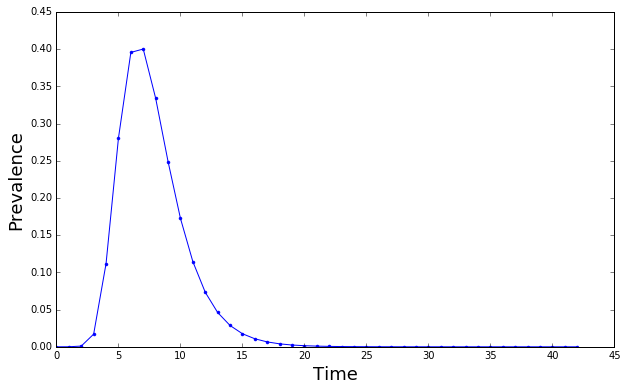

In [22]:
plt.figure()
plt.plot(xrange(0,len(I_net)), [float(n)/G.vcount() for n in I_net], '.-' )
plt.xlabel('Time', fontsize=18)
plt.ylabel('Prevalence', fontsize=18)
plt.show()

In [23]:
recovered = len([n for n in G.vs["disease_status"] if n == -1])
final_t = len(I_net)

print "Total number of nodes", G.vcount()
print "The total number of recovered nodes is", recovered
print "The final attack rate is", float(recovered)/G.vcount()
print "The epidemic is over at time", final_t

Total number of nodes 1222926
The total number of recovered nodes is 1109878
The final attack rate is 0.90755941079
The epidemic is over at time 43


### Part 2.1

In this part I have extended what done in the previous points with iterations and different strategy.

I have choose 100 iterations and a set of sentinel nodes with size 5% of the total nodes. $\mu$ and $\sigma$ is the same used before.

In [27]:
itr = 100
p = 0.05
N = int(G.vcount()*p)
mu = 0.4
beta = 0.6

The sentinels are choosen randomly from the nodes dataset.

In [28]:
sentinels = random.sample(range(G.vcount()), N)

Differently from the previous points, in this case we are interested to see the distribution of the arrival time at the sentinels of the epidemic. In particular the $6^{th}$-args of the function call choose the return values. A boxplot help us to understand the distribution of the arrival time with the same seed and sentinels.

In [29]:
avg_SIR = SIR_model(G,mu,beta,itr,seed,False,sentinels)

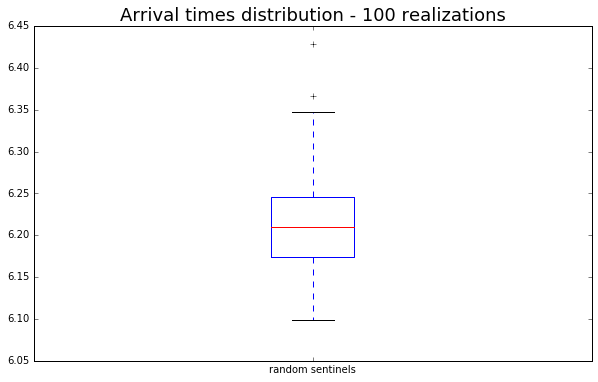

In [31]:
plt.boxplot(avg_SIR)
plt.title('Arrival times distribution - 100 realizations', fontsize=18)
plt.xticks([1],['random sentinels'])
plt.show()

### Part 2.2

An other possible study will be a repetition of the function ~100 times with different sentinels to stabilize the variability due to the choose sentinel's. To solve this problem, we have repeat the previous point 1 hundred times with new sentinels at each time. The results are displayed at the end of the computation.

In [64]:
avg_rnd_SIR = [np.mean(SIR_model(G,mu,beta,itr,seed,False,random.sample(range(G.vcount()), N))) for i in range(50)]

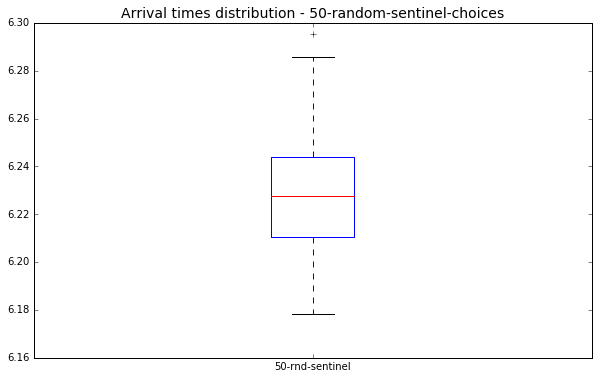

In [76]:
plt.boxplot(avg_rnd_SIR)
plt.title('Arrival times distribution - 50-random-sentinel-choices', fontsize=14)
plt.xticks([1],['50-rnd-sentinel'])
plt.show()

###  Part 2.3

In this part we have considered three different strategies to choose the sentinels. In particular we have used three metric: degree centrality, eigenvalue centrality and pagerank centrality.

*Degree centrality*: refers to the number of edges attached to the node.

*Eigenvector centrality*: is a measure of the influence of a node in a network. It assigns relative scores to all nodes in the network based on the concept that connections to high-scoring nodes contribute more to the score of the node in question than equal connections to low-scoring nodes. 

*PageRank centrality*: ranking of the nodes in the graph based on the structure of the incoming links. 

For each of the previous metrics we have choose the top and bottom -N nodes as sentinels.

In [32]:
dc = np.argsort(G.vs["degree"]).tolist()
bot_dc, top_dc = dc[:N],dc[-N:]

ec = np.argsort(G.evcent()).tolist()
bot_ec, top_ec = ec[:N],ec[-N:]

pr = np.argsort(G.pagerank()).tolist()
bot_pr, top_pr = pr[:N],pr[-N:]

In [33]:
bot_dc_SIR = SIR_model(G,mu,beta,itr,seed,False,bot_dc)

In [34]:
top_dc_SIR = SIR_model(G,mu,beta,itr,seed,False,top_dc)

In [35]:
bot_ec_SIR = SIR_model(G,mu,beta,itr,seed,False,bot_ec)

In [36]:
top_ec_SIR = SIR_model(G,mu,beta,itr,seed,False,top_ec)

In [37]:
bot_pr_SIR = SIR_model(G,mu,beta,itr,seed,False,bot_pr)

In [38]:
top_pr_SIR = SIR_model(G,mu,beta,itr,seed,False,top_pr)

In [77]:
avg_time_centrality = [avg_rnd_SIR, bot_dc_SIR, top_dc_SIR, bot_ec_SIR, top_ec_SIR, bot_pr_SIR, top_pr_SIR]

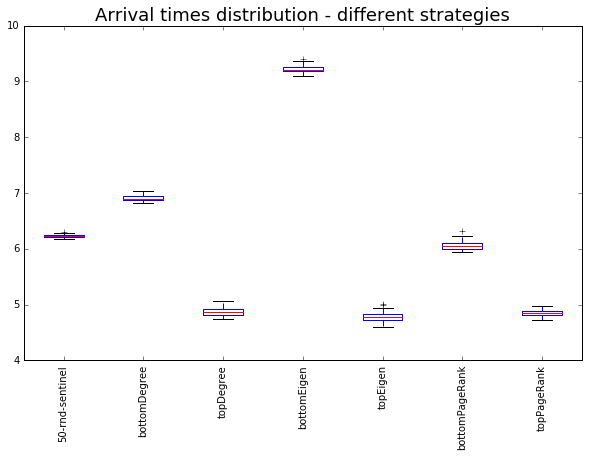

In [78]:
plt.figure()
plt.boxplot(avg_time_centrality)
plt.xticks([1,2,3,4,5,6,7],['50-rnd-sentinel','bottomDegree','topDegree','bottomEigen','topEigen','bottomPageRank','topPageRank'], rotation='vertical')
plt.title('Arrival times distribution - different strategies', fontsize=18)
plt.show()

In this plot we compare the different strategies. As we can see, the bottom nodes for each metrics take more time before to notify the infection respect to the top nodes. In degree centrality the top nodes are connected with the largest amount of nodes and therefore are more susceptible to be infect. In eigenvector centrality we not consider only the connection links in-out of the nodes, but also the connections of the neighbors. If a node have an high eigenvector centrality it have a lot of link to it and a dense neighbor network. PageRank is a variant of the eigenvector centrality but the main principle theory is the same. At the other side, the nodes with low degree, eigenvector and pagerank centrality are isolated nodes, with a lower probability to be reached by the epidemic and with a higher time to notify it.

Also, the top-selection-metrics nodes are better than the stabilized versione of the random selection.

### Part 3

As last part we select N nodes at random and we assume to do not have global information about the graph, but only about the graph neighborhoods of the chosen nodes.

The challenge is to build another set of N nodes that improves (reduce) the average detection time of the epidemic.

The friendship paradox is the phenomenon first observed by the sociologist Scott L. Feld in 1991 that most people have fewer friends than their friends have, on average. the phenomenon is a consequence of the general mathematical properties of social networks, that is the arithmentic-geometric mean inequality and the Cauchy-Schwarz inequality.

In addition to the mathematical properties we have see at the previous point the importance of an higher centrality to reduce the arrival time. 

To do it we have choose from the subgraph induced by the random nodes and their neighbors the degree *top*-N nodes and we have try to improve the arrival time. It is useful repeat more time (50) to have more strength.

In [ ]:
time_rnd = []
time_top_dc = []

for i in range(50):
    sentinels_rnd = random.sample(range(G.vcount()), N)
    nodes_subgraph = list(sentinels_rnd)
    nodes_subgraph.extend(list(set(itertools.chain.from_iterable(G.vs[sentinels]['neighbors']))))
    G_sub = G.subgraph(nodes_subgraph)
    seed = G_sub.degree().index(max(G_sub.degree()))
    sentinels_top_dc = np.argsort(G_sub.degree()).tolist()[-N:]
    rnd_sub_SIR = SIR_model(G,mu,beta,itr,seed,False,sentinels_rnd)
    top_dc_sub_SIR = SIR_model(G,mu,beta,itr,seed,False,sentinels_top_dc)
    
    time_rnd.append(np.mean(rnd_sub_SIR))
    time_top_dc.append(np.mean(top_dc_sub_SIR))

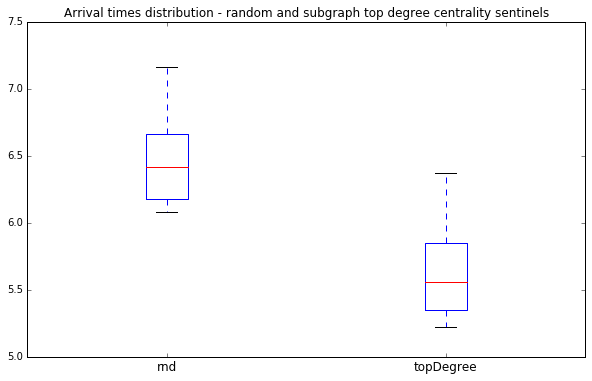

In [63]:
plt.figure()
plt.boxplot([time_rnd,time_top_dc])
plt.xticks([1, 2], ['rnd','topDegree'], fontsize=12)
plt.title('Arrival times distribution - random and subgraph top degree centrality sentinels')
plt.show()

As expected, our choice are good to improve the arrival time.

#### 97 rows